In [2]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext training_rl
%set_random_seed 12

In [3]:
%presentation_style

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


In [5]:
%autoreload
from training_rl.offline_rl.load_env_variables import load_env_variables
load_env_variables()

import os
import warnings
from copy import copy
import numpy as np

import gymnasium as gym
import minari
import torch

from training_rl.offline_rl.behavior_policies.behavior_policy_registry import \
    BehaviorPolicyType
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import \
    ObstacleTypes
from training_rl.offline_rl.custom_envs.custom_envs_registration import (
    CustomEnv, RenderMode, register_grid_envs, EnvFactory)
from training_rl.offline_rl.custom_envs.utils import (
    Grid2DInitialConfig, InitialConfigCustom2DGridEnvWrapper)
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import (
    MinariDatasetConfig, create_minari_datasets)
from training_rl.offline_rl.offline_policies.offpolicy_rendering import \
    offpolicy_rendering
from training_rl.offline_rl.offline_policies.policy_registry import PolicyName
from training_rl.offline_rl.offline_trainings.offline_training import \
    offline_training
from training_rl.offline_rl.offline_trainings.policy_config_data_class import (
    TrainedPolicyConfig, get_trained_policy_path)
from training_rl.offline_rl.offline_trainings.restore_policy_model import \
    restore_trained_offline_policy
from training_rl.offline_rl.utils import (compare_state_action_histograms,
                                          load_buffer_minari,
                                          state_action_histogram)
from training_rl.offline_rl.visualizations.utils import (
    get_state_action_data_and_policy_grid_distributions, snapshot_env, trajectory_cumulative_rewards_plot)
from training_rl.offline_rl.utils import widget_list
from training_rl.offline_rl.generate_custom_minari_datasets.generate_minari_dataset_grid_envs import \
    create_combined_minari_dataset
from training_rl.offline_rl.utils import load_buffer_minari, widget_list
from tianshou.data import Batch
from training_rl.offline_rl.visualizations.utils import compute_corrected_actions_from_policy_guided
from training_rl.offline_rl.behavior_policies.behavior_policy_registry import \
    BehaviorPolicyRestorationConfigFactoryRegistry
from training_rl.offline_rl.offline_policies.policy_registry import PolicyFactoryRegistry
from training_rl.offline_rl.offline_policies.dagger_torcs_policy import model_dagger_fit
from training_rl.offline_rl.offline_trainings.training_decision_transformer import evaluate_on_env
from training_rl.offline_rl.offline_policies.decision_transformer_policy import get_decision_transformer_default_config, \
    create_decision_transformer_policy_from_dict


# Only for Docker
#os.environ['PATH'] = '/opt/conda/bin:/opt/conda/condabin:/tmp/code/.venv/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/jovyan/tfl-training-rl/torcs/BUILD/bin'

warnings.filterwarnings("ignore")

render_mode = RenderMode.RGB_ARRAY_LIST if os.environ.get("DISPLAY") else None

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title"> Imitation Learning </div>

# Imitation Learning

**Imitation learning is a supervise learning approach that focuses on learning policies or behaviors by observing and imitating expert demonstrations**. Instead of learning from trial and error, imitation learning leverages existing expert knowledge to train agents.

This makes these algorithms appealing as, **you don't need to create a reward function for your task**, like in situations where the manual approach becomes essential because creating a reward function directly is not feasible, such as when training a self-driving vehicle.

## Behavioral Clonning (BC)

Behavioral Cloning (BC) is one of the simplest imitation learning algorithms, which essentially involves applying supervised learning to expert data collected during demonstrations:


$$ D = \{(s_0, a_0), (s_1, a_1), \ldots, (s_T, a_T)\} \quad \tag{Dataset} $$

$$\text{where} \quad \pi_{\theta^*}(s_t) \text{ s.t. } \theta^* = argmin_\theta  L_{BC}(\theta) \tag{learned policy}$$

$$\text{with} \quad L_{BC}(\theta) = \sum_{t=0}^T \left(\pi_\theta(s_t) - a_t\right)^2 \tag{Cost function}$$


and, $\pi_\theta(s_t)$, typically a DNN. In essence, BC aims to minimize the discrepancy between the actions produced by the learned policy and the actions demonstrated by the expert, making it a straightforward approach to imitation learning.

### Exercise I

**In this exercise, we will work with a simple example of Behavioral cloning (BC) . The goal is to explore some of the issues with imitation learning and become familiar with the Tianshou library for offline RL training!** . 

**For this exercise, there's no homework required. However, please take some time to familiarize yourself with the code provided. These concepts will be revisited often in subsequent exercises.**

In the code below, we will create a Minari dataset, as we did previously, but this time we will use the function **create_minari_datasets(...)** which saves some useful metadata. This metadata is important for recreating the environment associated with the data when testing our trained policy.

We will also utilize one of our registered behavioral policies.


The pipeline will be the following:

<img src="_static/images/93_offline_RL_pipeline.png" alt="Snow" style="width:80%;">

Before to go on let's take a look to the code structure:

<img src="_static/images/93_code_structure.png" alt="Snow" style="width:40%;">

Regarding trainings we will use often the function:

offline_training(
    offline_policy_config = OFFLINE_POLICY_CONFIG,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
    batch_size=BATCH_SIZE
)

This is essentially a wrapper around the Tianshou OfflineTrainer class. It takes the OFFLINE_POLICY_CONFIG, which is of type TrainedPolicyConfig and contains useful information about the policy to be trained as well as the dataset used for training. The wrapper then trains the policy in batches of BATCH_SIZE from the dataset, ensuring that the number of steps collected from the data in every epoch does not exceed STEP_PER_EPOCH.

Let's go to the exercise now!

**Create the environment**

In [ ]:
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete.value

OBSTACLE = ObstacleTypes.obst_big_8x8
INITIAL_STATE = (0, 0)
FINAL_STATE = (0, 7)

env_2D_grid_initial_config = Grid2DInitialConfig(
    obstacles=OBSTACLE,
    initial_state=INITIAL_STATE,
    target_state=FINAL_STATE,
)

env = EnvFactory[ENV_NAME].get_env(render_mode=RenderMode.RGB_ARRAY_LIST,grid_config=env_2D_grid_initial_config)

snapshot_env(env)

**Behavior policies configuration**

In [ ]:
BEHAVIOR_POLICY_I = BehaviorPolicyType.behavior_8x8_suboptimal_initial_0_0_final_0_7
DATA_SET_IDENTIFIER_I = "_suboptimal_exercise_I_nb_93"
NUM_STEPS_I = 500

BEHAVIOR_POLICY_II = BehaviorPolicyType.random
DATA_SET_IDENTIFIER_II = "_random_exercise_I_nb_93"
NUM_STEPS_II = 50000

In [ ]:
behavior_policy_selected = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II])

In [ ]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=render_mode,
    behavior_policy_name=behavior_policy_selected.value,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
)

**Collect Minari dataset**

Note that we have more noisy data than expert information, but we still have enough expert data in proportion. This situation is not so common in realistic problems, where expert (or close-to-expert) data is challenging to collect.

In [ ]:
config_combined_data = create_combined_minari_dataset(
        env_name=ENV_NAME,
        dataset_identifiers = (DATA_SET_IDENTIFIER_I, DATA_SET_IDENTIFIER_II),
        num_collected_points = (NUM_STEPS_I, NUM_STEPS_II),
        behavior_policy_names = (BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
        combined_dataset_identifier = "combined_dataset",
        env_2d_grid_initial_config = env_2D_grid_initial_config,
)
buffer_data = load_buffer_minari(config_combined_data.data_set_name)
data_size = len(buffer_data)

**Let's take a look at the state-action data distribution.** 

We will be using the Tianshou RL library, so we'll load the previously collected dataset into a Tianshou ReplayBuffer object.

In [ ]:
dataset_availables = [config_combined_data.data_set_name] + config_combined_data.children_dataset_names
selected_data_set = widget_list(dataset_availables)

In [ ]:
buffer_data = load_buffer_minari(selected_data_set.value)
len_buffer = len(buffer_data)

# Compute state-action data distribution
state_action_count_data, _ = get_state_action_data_and_policy_grid_distributions(buffer_data, env)
state_action_histogram(state_action_count_data, title="State-Action data distribution")
snapshot_env(env)

Do the state-action distributions make sense?

**Let's train our first offline RL algorithm: Imitation Learning.**

Before we proceed, let's take a moment to become a little more familiar with the code. Let's spend some minutes reviewing:

    a - il_policy.py
    b - policy_registry.py
    c - offline_training.py


In [ ]:
#The model policy to be trained.

POLICY_NAME = PolicyName.imitation_learning

NUM_EPOCHS = 5
BATCH_SIZE = 128
STEP_PER_EPOCH = len_buffer

# After every epoch we will collect some test statistics from the policy from NUMBER_TEST_ENVS independent envs.
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None #1626

# TrainedPolicyConfig is a handy object that will help us to deal with the policy configuration data.
offline_policy_config = TrainedPolicyConfig(
    name_expert_data=selected_data_set.value,
    policy_name=POLICY_NAME,
    render_mode=render_mode,
    device="cpu"
)

# Run the training
offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs = NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=STEP_PER_EPOCH,
    restore_training=False,
    batch_size=BATCH_SIZE
)

**Let's take a look at the state-action BC policy distribution.**

In [ ]:
POLICY_FILE = "policy.pth"
NUM_EPISODES = 40 # as more episodes the better

# restore a policy with the same configuration as the one we trained.
policy = restore_trained_offline_policy(offline_policy_config)
# load the weights
name_expert_data = offline_policy_config.name_expert_data
log_name = os.path.join(name_expert_data, POLICY_NAME)
log_path = get_trained_policy_path(log_name)
policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_FILE), map_location="cpu"))

# compute statistics
state_action_count_data, state_action_count_policy = \
    get_state_action_data_and_policy_grid_distributions(
    buffer_data, 
    env, 
    policy, 
    num_episodes=NUM_EPISODES,
    logits_sampling=True,
)

# plots
state_action_histogram(state_action_count_data, title="State-Action data distribution")
new_keys = [(env.to_xy(state_action[0]), state_action[1]) for state_action in list(state_action_count_data.keys())]
state_action_histogram(state_action_count_policy, title="State-Action policy distribution")
compare_state_action_histograms(state_action_count_data, state_action_count_policy)
snapshot_env(env)

As expected, the learned policy has a very similar distribution to the dataset!

**Let's now visualize the policy**

Below the imitation_policy_sampling=False arguments will give us the $\arg \max_a \pi(s|a)$. By setting it to True you will be sampling actions from the policy.

In [ ]:
offpolicy_rendering(
    env_or_env_name=env,
    render_mode=render_mode,
    policy_model=policy,
    env_2d_grid_initial_config=env_2D_grid_initial_config,
    num_frames=1000,
    imitation_policy_sampling=False
)

**As our dataset includes a fair amount of expert data, by taking the $\arg \max_a \pi(s|a)$, we are able to remove the noise from the data and obtain the expert policy. This is a nice property of imitation learning! But if the expert data is not enough the BC algorithm will imitate the noise and the policy will be far from optimal.**

### Exercise II

Try now the following:

**a - Start the agent from a different position. What happens?.**

**b - Remove the obstacle and examine the state-action distribution. What do you observe? Can you explain it?.
      What do you think would happen if you start the agent from a previously forbidden position?**
      
**c -  Let's revisit Exercise I and see what happens if you increase the noise significantly, like to 40K-50K?**


Hint: You can use a different ObstacleTypes.obst_free_8x8 in your configuration and change the initial state, like this:

    NEW_INITIAL_STATE = (1,0)
    env.set_new_obstacle_map(ObstacleTypes.obst_free_8x8.value)
    env.set_starting_point(NEW_INITIAL_STATE)

**SOLUTION a**

In [ ]:
obstacle_availables = [ObstacleTypes.obst_free_8x8, ObstacleTypes.obst_big_8x8]
selected_obstacle = widget_list(obstacle_availables)

In [ ]:
NEW_INITIAL_STATE = (2,2)
env.set_starting_point(NEW_INITIAL_STATE)
env.set_new_obstacle_map(selected_obstacle.value.value) #ObstacleTypes.obst_big_8x8

offpolicy_rendering(
    env_or_env_name=env,
    render_mode=RenderMode.RGB_ARRAY_LIST,
    policy_model=policy,
    num_frames=1000,
    imitation_policy_sampling=False
)

**SOLUTION b**

In [ ]:
NUM_EPISODES = 20
env.set_starting_point((0,0))
env.set_new_obstacle_map(ObstacleTypes.obst_free_8x8.value)


state_action_count_data, state_action_count_policy = \
    get_state_action_data_and_policy_grid_distributions(
    buffer_data, 
    env, 
    policy, 
    num_episodes=NUM_EPISODES,
    logits_sampling=True,
)

state_action_histogram(state_action_count_data, title="State-Action data distribution")
new_keys = [(env.to_xy(state_action[0]), state_action[1]) for state_action in list(state_action_count_data.keys())]
state_action_histogram(state_action_count_policy, title="State-Action policy distribution")
compare_state_action_histograms(state_action_count_data, state_action_count_policy)
snapshot_env(env)

Keep in mind that in real-life scenarios, the forbidden zone—represented by the black region in the original environment—might correspond to a playground or a garden. There could be valid reasons for avoiding this area, so it's crucial not to enter it. If an agent does venture into this forbidden zone, it should strive to return to in-distribution states. Offline reinforcement learning (RL) addresses this challenge, as we will explore.

**SOLUTION c**

As you can see, increasing the noise level causes the trained policy to mimic the noise, resulting in a far from policy.

**DISTRIBUTIONAL SHIFT EFFECT**: As we observed in the previous exercises, a distributional shift effect often occurs, primarily due to out-of-distribution state-action pairs as the agent explores unfamiliar areas. This undesired effect is caused by function approximation, meaning that the DNN policy cannot perfectly represent the state-action distribution in regions with limited or no data. Eliminating this effect is crucial. Near unexplored regions, the policy's behavior becomes unpredictable.

### Error between the behavior and learned policies.

Let's try to be a bit more formal and compute an upper bound for the error between the behavioral and learned policies in the figure below.

<img src="_static/images/93_imitation_learning.png" alt="Snow" style="width:80%;">
<div class="slide title"> Fig.1 Once out-of-distribution BC agent is unlikely to recover </div>

Consider a cost function given by: $ c(s,a) = 0  \text{ if } a = \pi^\beta(s)$, otherwise $c(s,a)=1$, where $\pi^\beta(s)$ represents the behavior policy.  Additionally, assume that $ \pi_\theta (a \ne \pi^\beta(s) | s) \le \epsilon \text{ for all } s \in D_{\text{train}} $ . The total error can then be estimated as:

$$ \mathbb{E} \left[ \sum_t c(s_t, a_t) \right] \le \epsilon H + (1 - \epsilon) (\epsilon (H-1) +  ... ) \sim O(\epsilon H²)$$

with $H$ being the time horizon.

Exercise: What is the error if the episode terminate as soon as you are out-of-distribution?

Solution: The error is of $O(\epsilon H)$.

### Summary

**Pros**:

a - BC becomes interesting when one has access to noisy expert data, as it provides a means to reduce noise from the expert data.**

b - Another noteworthy aspect of BC is that it doesn't rely on rewards, making it a less complex solution to the problem of reward shaping in reinforcement learning.**

**Cons**: 

a - in realistic applications, obtaining expert data is often a challenge. In many cases, we have access to only a limited number of trajectories, rendering this method less useful for extracting optimal policies. 

b - as we've observed, encountering o.o.d. scenarios (common during inference when visiting state-actions not included in the training dataset) causes BC to behave unpredictably. This unpredictability arises due to the lack of feedback typically present in online RL settings.

c - Additionally, simple imitation learning approaches often struggle to address an important property mentioned in the Minari datasets introduction (nb_91), known as the stitching property. This property refers to the ability of the learned policy to combine suboptimal trajectories into better ones, which is crucial in real-world problems.

We will explore later how offline RL provides a strategic approach to address these drawbacks.

## Behavioral Clonning Improvements

### DAGGER (Dataset Aggregation)

Improved versions of Behavioral Cloning (BC), such as DAgger (Dataset Aggregation), involve **rolling out the policy after initial BC training**. If **new states** emerge during rollout, **additional feedback is sought from human experts**. While this approach can lead to significant improvements, it can also incur substantial costs.

<img src="_static/images/93_dagger_pseudocode.png" alt="Snow" style="width:80%;">
<div class="slide title"> Fig.2: DAGGER pseudocde </div>

Note that the error in Dagger is: $$ \mathbb{E} \left[ \sum_t c(s_t, a_t) \right] \sim O(\epsilon H)$$

**Dagger is powerful but impractical, as it gradually expands the dataset by incorporating new states and actions with expert knowledge in each iteration. This approach aligns more closely with online RL methodologies and is not typically feasible in offline RL, where states not included in the dataset are typically inaccessible.**

In the following sections, we'll work with a race simulator called TORCS. Our goal is to develop an imitation learning policy that autonomously learns driving techniques from an expert driver, leveraging lidar sensors to navigate a race circuit. We'll initially apply Behavioral Cloning (BC) and then assess the improvements achieved by employing DAGGER

#### TORCS short introduction

TORCS (The Open Racing Car Simulator) is a free 3D car racing game made in C++. TORCS allows easy addition of AI controllers for cars, making it popular for AI research in racing. It has a complex physics engine that considers things like aerodynamics, wheel rotation, car damage, and fuel, providing a detailed environment for learning by agents.

<img src="_static/images/93_TORCS_simulator.png" alt="Snow" style="width:80%;">
<div class="slide title"> Fig 3: TORCS simulator </div>

In TORCS, cars usually know everything about the game, like the surroundings and other cars, which isn't like real autonomous agents. To make it more realistic, the server acts as a middleman between the game and the player's control of a single car. The controllers are separate programs that talk to TORCS through the server using UDP connections. The server tells the controller what the car senses, and the controller decides how the car should act. This setup makes the controller act like an independent agent in the game.

**Let's take a look at TORCS and see how it works.**

Please configure TORCS with the following settings (go to RACE - PRACTICE - CONFIGURE RACE):

**Track: E-Track 4**
**Driver: scr_server_1**

These configurations are to be used in the upcoming exercises

In [ ]:
os.system('torcs')

#### Exercise III

In this exercise, we will focus on training a single car to drive autonomously using collected data that may not be optimal. As a result, Behavioral Cloning (BC) may not produce an optimal policy based on this data alone. However, the DAGGER aggregation method, utilizing an expert policy, has the potential to refine the policy to a near-optimal level relatively quickly.

We have integrated the simulator into a gymnasium environment. Our observations will be based on a lidar system with 19 rays, while our actions will primarily involve steering. It's worth noting that the environment also allows control over acceleration and gear, and there is an abundance of observations provided by the simulator.

<img src="_static/images/93_torcs_circuit.png" alt="Snow" style="width:40%">
<div class="slide title"> Fig 4: We will use the E-Track 4. </div>

**Create TORCS Minari datasets**

In [ ]:
ENV_NAME = EnvFactory.torcs
BEHAVIOR_POLICY_I = BehaviorPolicyType.torcs_expert_policy_with_noise
BEHAVIOR_POLICY_II = BehaviorPolicyType.torcs_expert_policy
BEHAVIOR_POLICY_III = BehaviorPolicyType.torcs_drunk_driver_policy

**Visualize TORCS behavior policies**

**Pay close attention to the behavior of the 'expert_noisy' policy, noting that the car drifts off the road after a few meters.**

In [ ]:
policy_selected_to_visualize = widget_list([BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II, BEHAVIOR_POLICY_III])

In [ ]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=None,
    behavior_policy_name=policy_selected_to_visualize.value,
    num_frames=4000,
)

**Create minari dataset**

We will train the policy using the 'expert_and_noise' dataset, but we will also collect expert data for later comparison and analysis.

In [ ]:
DATA_SET_NAME_I = "torcs_expert_and_noise"
NUM_STEPS_I = 3000
DATA_SET_NAME_II = "torcs_expert"
NUM_STEPS_II = 7000
DATA_SET_NAME_III = "torcs_suboptimal"
NUM_STEPS_III = 6000


config_minari_data_I_and_II = create_combined_minari_dataset(
    env_name=ENV_NAME,
    dataset_names=(DATA_SET_NAME_I, DATA_SET_NAME_II),
    num_collected_points=(NUM_STEPS_I, NUM_STEPS_II),
    behavior_policy_names=(BEHAVIOR_POLICY_I, BEHAVIOR_POLICY_II),
    combined_dataset_identifier="torcs_driver_expert_and_expert_plus_noise",
)


config_minari_suboptimal = create_minari_datasets(
    env_name = ENV_NAME,
    dataset_name = DATA_SET_NAME_III,
    num_colected_points = NUM_STEPS_III,
    behavior_policy_name = BEHAVIOR_POLICY_III,
)

collected_datasets_names = [config_minari_data_I_and_II.data_set_name] + config_minari_data_I_and_II.children_dataset_names + [config_minari_suboptimal.data_set_name]


_ = os.system("pkill torcs")

#### Exercise III-a

a - Use Behavioral Cloning (BC) to train the imitation learning policy based on the "torcs_expert_and_noise" dataset. Just let it run for a few epochs.

b - Visualized the policy and extract conclusions.

**SOLUTION:**

In [ ]:
collected_datasets_names = ["torcs-torcs_driver_expert_and_expert_plus_noise-v0", "torcs-torcs_expert_and_noise-v0", "torcs-torcs_expert-v0", "torcs-torcs_suboptimal-v0"]
collected_datasets = widget_list(collected_datasets_names)

In [ ]:
NUM_EPOCHS = 6
BATCH_SIZE = 128
NUMBER_TEST_ENVS = 1
EXPLORATION_NOISE = True
SEED = None  # 1626
PERCENTAGE_DATA_PER_EPOCH = 1.0
DEVICE = "cuda"

OFFLINE_POLICY_NAME = PolicyName.imitation_learning_torcs
DATA_SET_NOISY_NAME = collected_datasets.value
TRAINED_POLICY_NAME = "policy_bc.pt"

**Train policy**

In [ ]:
buffer_data = load_buffer_minari(DATA_SET_NOISY_NAME)
data_config = MinariDatasetConfig.load_from_file(DATA_SET_NOISY_NAME)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=DATA_SET_NOISY_NAME,
    policy_name= OFFLINE_POLICY_NAME,
    device=DEVICE
)


offline_training(
    offline_policy_config=offline_policy_config,
    num_epochs=NUM_EPOCHS,
    number_test_envs=NUMBER_TEST_ENVS,
    step_per_epoch=PERCENTAGE_DATA_PER_EPOCH * len(buffer_data),
    restore_training=False,
    batch_size=BATCH_SIZE,
    policy_name=TRAINED_POLICY_NAME,
)

**Let's visualize the trained policy**

In [ ]:
trained_policy_selected = widget_list([TRAINED_POLICY_NAME])

In [ ]:
trained_bc_policy = restore_trained_offline_policy(offline_policy_config)
log_name = os.path.join(DATA_SET_NOISY_NAME, OFFLINE_POLICY_NAME)
log_path = get_trained_policy_path(log_name)
trained_bc_policy.load_state_dict(torch.load(str(os.path.join(log_path, trained_policy_selected.value)), map_location="cpu"))

offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=None,
    policy_model=trained_bc_policy,
    num_frames=5000,
)

**Let's see what would happen if we drive with the learned policy and compare the actions taken by the learned policy with those that would have been taken by the expert.**

In [ ]:
_ = compute_corrected_actions_from_policy_guided(
    env_name=ENV_NAME,
    policy_guide=trained_bc_policy,
    policy_a=BehaviorPolicyType.torcs_expert_policy,
    num_steps=3000,
)

Clearly, BC was able to reduce noise and extract expert knowledge from the data! You can compare with the noisy policy:

In [ ]:
_ = compute_corrected_actions_from_policy_guided(
    env_name=ENV_NAME,
    policy_guide=BehaviorPolicyType.torcs_expert_policy_with_noise,
    policy_a=BehaviorPolicyType.torcs_expert_policy,
    num_steps=3000,
)

In our example, we have taken much more expert data than noise. However, if you increase the amount of data, the policy won't be able to mimic the expert policy at all. Instead, it will imitate the noise, behaving in an unpredictable way.

#### Exercise III-b

Let's now train a BC policy using the "torcs_suboptimal" dataset. You can revisit Exercise III-a and rerun the training for a few epochs. What observations do you make?

**SOLUTION**: When the data is suboptimal, the BC algorithm struggles to make improvements. However, as we'll explore in the next exercise, DAGGER can effectively enhance the BC policy using expert feedback.

#### Exercise III-c

**Let's determine the optimal policy using the DAGGER algorithm with the 'torcs_suboptimal' dataset. We'll start by using the BC policy trained in Exercise III-b. If the BC policy isn't well-trained, there's no need to worry, it doesn't need to be robust for DAGGER implementation. Your goal is to implement a basic DAGGER algorithm following the pseudocode outlined in Figure 2.**

**1 - Restore initial BC policy**

In [ ]:
DATA_SET_SUBOPTIMAL_NAME = "torcs-torcs_suboptimal-v0"
POLICY_NAME_EXERCISE_III_B = "policy_bc.pt"
OFFLINE_POLICY_NAME = PolicyName.imitation_learning_torcs
DEVICE = "cuda"

DAGGER_NUM_STEPS = 5000
DAGGER_POLICY_NAME = "dagger_trocs.pt"
DAGGER_ITERS = 25


buffer_data = load_buffer_minari(DATA_SET_SUBOPTIMAL_NAME)
data_config = MinariDatasetConfig.load_from_file(DATA_SET_SUBOPTIMAL_NAME)

offline_policy_config = TrainedPolicyConfig(
    name_expert_data=DATA_SET_SUBOPTIMAL_NAME,
    policy_name= OFFLINE_POLICY_NAME,
    device=DEVICE
)


trained_bc_policy = restore_trained_offline_policy(offline_policy_config)
log_name = os.path.join(DATA_SET_SUBOPTIMAL_NAME, OFFLINE_POLICY_NAME)
log_path = get_trained_policy_path(log_name)
trained_bc_policy.load_state_dict(torch.load(os.path.join(log_path, POLICY_NAME_EXERCISE_III_B), map_location="cpu"))

**SOLUTION:**

**2 - initial expert correction**

In [ ]:
policy_expert = BehaviorPolicyRestorationConfigFactoryRegistry.torcs_expert_policy

initial_output = compute_corrected_actions_from_policy_guided(
    env_name=EnvFactory.torcs,
    policy_guide=trained_bc_policy,
    policy_a=policy_expert,
    #policy_b=trained_bc_policy,
    num_steps=DAGGER_NUM_STEPS,
    visualize=True
)

**3  - create our dagger policy (we could use the previous BC one but we will create a new one).**

In [ ]:
dagger_offline_policy = PolicyFactoryRegistry.dagger_torcs()

corrected_actions = np.array(initial_output["actions_corrected_policy"])
collected_states = np.array(initial_output["collected_states"])

for dagger_iter in range(DAGGER_ITERS):

    model_dagger_fit(
        input_data=torch.Tensor(collected_states),
        target_data=torch.Tensor(corrected_actions),
        model=dagger_offline_policy
    )

    output = compute_corrected_actions_from_policy_guided(
        env_name=EnvFactory.torcs,
        policy_guide=dagger_offline_policy,
        policy_a=policy_expert,
        #policy_b=trained_bc_policy,
        num_steps=DAGGER_NUM_STEPS,
        visualize=True
    )

    corrected_actions = np.concatenate([np.array(output["actions_corrected_policy"]), corrected_actions], axis=0)
    collected_states = np.concatenate([np.array(output["collected_states"]), collected_states], axis=0)



In [ ]:
offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=None,
    policy_model=dagger_offline_policy,
    num_frames=5000,
)

## Imitation Learning with Decision transformers

Decision Transformer is an imitation learning approach through a conditional sequence modelling that can generate future actions that achieve the **desired return**, i.e. you condition on the rewards. Note that this is in contrast to RL where you always try to find the policy that maximizes the reward.

<img src="_static/images/93_decision_transformer.png" alt="Snow" style="width:200%;">
<div class="slide title"> Fig.5: Decision Transformer </div>


Basically our policy will be given by:

$$
\pi(a_t | s_0, R_0, a_0,  s_1, R_1, a_1,  ... , s_{t-1}, R_{t-1}, a_{t-1}, s_t, R_t)
$$ 

where $R_t$ is the return to go or cumulative reward at time t, i.e. $R_t = \sum_{t'=0}^{\infty} r_{t + t' + 1}$ .
Observe that this is a bit more intrincate than the algorithms before as here we need to have access to the rewards. This is not always simple as with expert data it is often the human that provides the reward feedback implicitly.


The idea is simple:
<img src="_static/images/93_decision_transformer_2.png" alt="Snow" style="width:200%;">
<div class="slide title"> Fig.6: How Decision Transformers work.  </div>


Note that a decision transformer is a powerful way to imitate the behavior you observe in expert data but, it 
lacks the temporal compositionality (i.e. the property to connect different trajectories to get a new one with a better reward) own by dynamic programming approaches like e.g. Q-learning. As we will see later, offline RL exploits this property quite a lot to find the optimal policy.

However, there are other similar methods that use transformers and incorporate, to some extent, the temporal compositional property. For instance, the trajectory transformer (https://arxiv.org/pdf/2106.02039.pdf) is similar to a Decision Transformer in that they both train a transformer architecture, as seen in Fig. 7.,

<img src="_static/images/93_levine_lecture_traj_transformer.png" alt="stich_traj" style="width:200%;">
<div class="slide title"> Fig.7: Trajectory Transformers.  </div>

to predict not only the next action but also the next state and reward. However, the main difference lies in the fact that, after training the transformer and considering it as a probability distribution of trajectories, it takes an additional step of planning using BEAM search:

<img src="_static/images/93_beam_search.png" alt="stich_traj" style="width:50%;"> 

This makes the algorithm more robust, as it allows it to concatenate independent trajectories, as we already discussed and depicted in the figure below.

<img src="_static/images/stiching.png" alt="stich_traj" style="width:40%;">

Finally, it is important to mention that you are not restricted to conditioning solely on the rewards; instead, you could condition on other quantities such as the target state (if applicable) or specific actions (such as the direction the car turns left), among others.

### Exercise 4

In [14]:
PATH_TO_DT_MODEL = \
        "../src/training_rl/offline_rl/data/decision_transformers/models/model_1000_ep_1000_steps_halfcheetah/model_d4rl_halfcheetah_medium_v0_April_24_v2.pt"
ENV_NAME = "HalfCheetah-v3"  # "Walker2d-v3"
DATASET_DT_PATH = "../src/training_rl/offline_rl/data/decision_transformers/d4rl_data/halfcheetah-medium-v0.pkl"
RENDER_MODE = True

In [15]:
env = gym.make(ENV_NAME, render_mode='rgb_array' if RENDER_MODE else None)

decision_transformer_config = get_decision_transformer_default_config()
decision_transformer_config["device"] = "cpu"
device = decision_transformer_config["device"]
context_len = decision_transformer_config["context_len"]

model = create_decision_transformer_policy_from_dict(
    config=decision_transformer_config,
    action_space=env.action_space,
    observation_space=env.observation_space
)

model.load_state_dict(torch.load(PATH_TO_DT_MODEL, map_location=device))
print("Policy loaded from: ", PATH_TO_DT_MODEL)

Policy loaded from:  ../src/training_rl/offline_rl/data/decision_transformers/models/model_1000_ep_1000_steps_halfcheetah/model_d4rl_halfcheetah_medium_v0_April_24_v2.pt


**Analysis of trained policy**

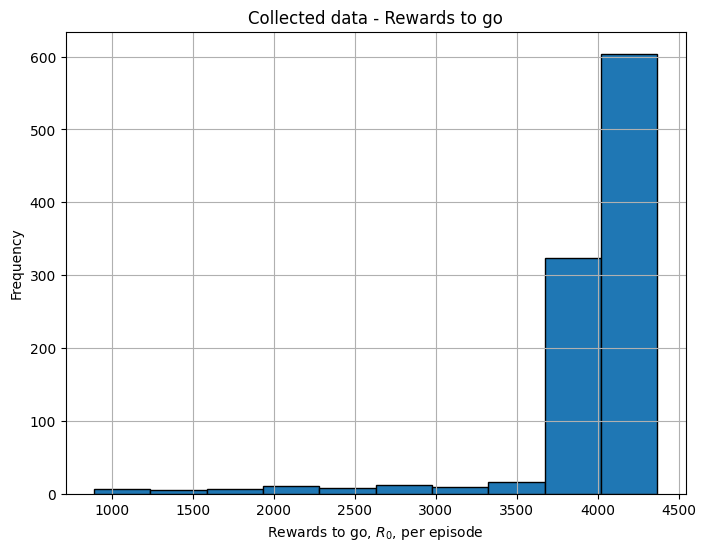

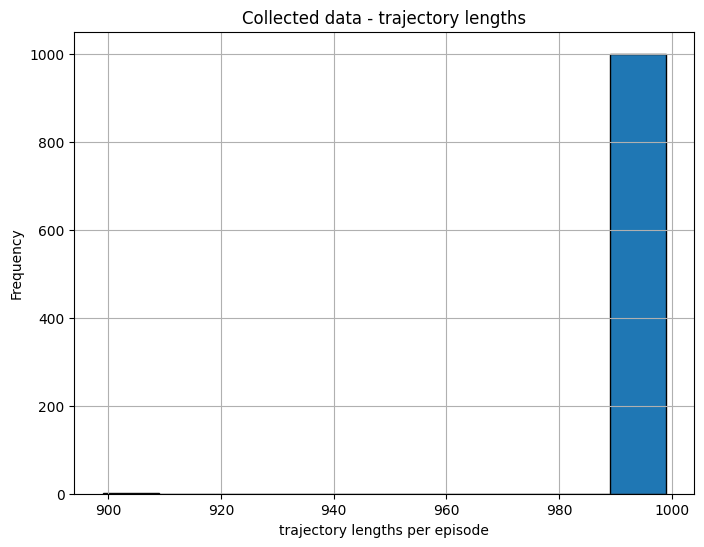

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
from itertools import accumulate

with open(DATASET_DT_PATH, 'rb') as f:
    trajectories_dataset = pickle.load(f)

cumulative_rewards_per_episode = []
trajectory_length_per_episode = []
for trajectory in trajectories_dataset:
    cumulative_rewards_per_episode.append(np.sum(trajectory['rewards']))
    trajectory_length_per_episode.append(len(trajectory['observations']))

    
def plot_hist(values, bins, x_label="", y_label="", title=""):    
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=bins, edgecolor='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_hist(
    values=cumulative_rewards_per_episode, 
    bins=10,
    x_label='Rewards to go, $R_0$, per episode',
    y_label='Frequency',
    title='Collected data - Rewards to go',
)

plot_hist(
    values=trajectory_length_per_episode, 
    bins=10,
    x_label='trajectory lengths per episode',
    y_label='Frequency',
    title='Collected data - trajectory lengths',
)

**Comparison trainig vs inference reward to go**

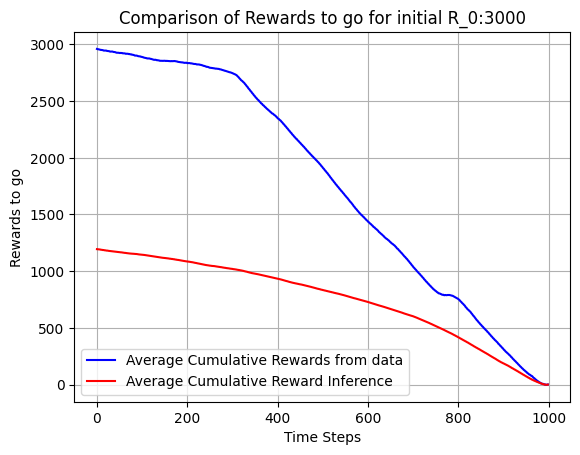

In [49]:
EVAL_RTG_TARGET = 3000
EVAL_RTG_SCALE = 1000

    
trajectory_cumulative_rewards_plot(
    env=env,
    model=model,
    initial_R_0=EVAL_RTG_TARGET, 
    trajectories_data=trajectories_dataset,
    eval_rtg_scale=EVAL_RTG_SCALE,
    num_episodes = 20,
    context_len=context_len,
)

**trained policy rendering**

In [42]:
NUM_STEPS_PER_EPISODE=4000
RENDER_RTG_TARGET = 1000

results = evaluate_on_env(
    model= model,
    device="cpu",
    context_len=context_len,
    env=env,
    rtg_target=RENDER_RTG_TARGET,
    rtg_scale=EVAL_RTG_SCALE,
    num_eval_ep=1,
    max_test_ep_len=NUM_STEPS_PER_EPISODE,
    render=True,
    )


**Summary**

 ## TODO's
 
 0 - See Torcs rewards.
 
 1 - Comment about Reinforcement Learning via Supervised Learning (RvS) --> lectures/video Levine. min.27.26
 
 2 -  CRITICAL action states 16.46
 
 3 - 1 - PDF with transformer theory
 
 4 - 2 - Train Cheetah with Decision Transformers

 5 - RTX-1 plux X-embodiment --> google colab official page of RTX-1 --> in Minari part maybe?
 
 
 7 - (ToDo or not ToDo: short intro to Transformers architecture? --> Maybe in a separate pdf.)
tokenize actions, memory, etc. etc. 
https://www.ias.informatik.tu-darmstadt.de/uploads/Teaching/HumanoidRoboticsSeminar/HR_Report_21_22_Timo_Imhof_Decision_Transformer.pdf)

8 - ToDo: RT-X 1 ???

https://github.com/google-deepmind/open_x_embodiment?tab=readme-ov-file

https://colab.research.google.com/github/google-deepmind/open_x_embodiment/blob/main/colabs/Minimal_example_for_running_inference_using_RT_1_X_TF_using_tensorflow_datasets.ipynb


9 - 00 - Explain training/evaluation code --> why predicted passed action doesn't change when become new inputs...

0 - Explain paper and see youtube paper explanation for some insights plus Levine theory.

1 - See behavior policy how it performs conditioned on different rewards.

2 - Compute cumulative rewards in inference for differents intiaial R_0 values to show how is the performance.
 
3 - Other analysis ??? 

and colab to visualize data.



DT --> **1 - ToDo or not ToDo: D4RL behavior policy visualization and download**

**2 - Show how to train the model**
